In [9]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')


# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

# 1. Separate data into train and test Manually

In [3]:
#  (no devset here)

# how many training examples
propTraining = .8 # in proportion, not percent
nTraining = int(len(labels)*propTraining)

# initialize a boolean vector to select data and labels
traintestBool = np.zeros(len(labels),dtype=bool)

# is this the correct way to select samples?
# traintestBool[range(nTraining)] = True

# this is better, but why?
items2use4train = np.random.choice(range(len(labels)),nTraining,replace=False)
traintestBool[items2use4train] = True

traintestBool

array([ True,  True, False,  True, False, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False,  True,  True,  True,
       False,  True,

In [4]:
# test whether it's balanced
print('Average of full data:')
print( torch.mean(labels.float()) ) # =1 by definition
print(' ')

print('Average of training data:')
print( torch.mean(labels[traintestBool].float()) ) # should be 1...
print(' ')

print('Average of test data:')
print( torch.mean(labels[~traintestBool].float()) ) # should also be 1...

Average of full data:
tensor(1.)
 
Average of training data:
tensor(0.9667)
 
Average of test data:
tensor(1.1333)


In [5]:
# create the ANN model

# model architecture
ANNiris = nn.Sequential(
    nn.Linear(4,64),   # input layer
    nn.ReLU(),         # activation unit
    nn.Linear(64,64),  # hidden layer
    nn.ReLU(),         # activation unit
    nn.Linear(64,3),   # output units
      )

# loss function
lossfun = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

In [6]:
# entire dataset
print( data.shape )

# training set
print( data[traintestBool,:].shape )

# test set
print( data[~traintestBool,:].shape )

torch.Size([150, 4])
torch.Size([120, 4])
torch.Size([30, 4])


## Train and test the model

In [ ]:
# train the model

numepochs = 1000

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []

# loop over epochs
for epochi in range(numepochs):

  # forward pass
  yHat = ANNiris(data[traintestBool,:])

  # compute accuracy (note: denser than previous code!)
  ongoingAcc.append( 100*torch.mean(
              (torch.argmax(yHat,axis=1) == labels[traintestBool]).float()) )

  # compute loss
  loss = lossfun(yHat,labels[traintestBool])
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

In [ ]:
# compute train and test accuracies

# final forward pass USING TRAINING DATA
predictions = ANNiris(data[traintestBool,:])
trainacc = 100*torch.mean((torch.argmax(predictions,axis=1) == labels[traintestBool]).float())


# final forward pass USING TEST DATA!
predictions = ANNiris(data[~traintestBool,:])
testacc = 100*torch.mean((torch.argmax(predictions,axis=1) == labels[~traintestBool]).float())

In [ ]:
# report accuracies

print('Final TRAIN accuracy: %g%%' %trainacc)
print('Final TEST accuracy:  %g%%' %testacc)

Final TRAIN accuracy: 97.5%
Final TEST accuracy:  96.6667%


# 2. Scikit-Learn

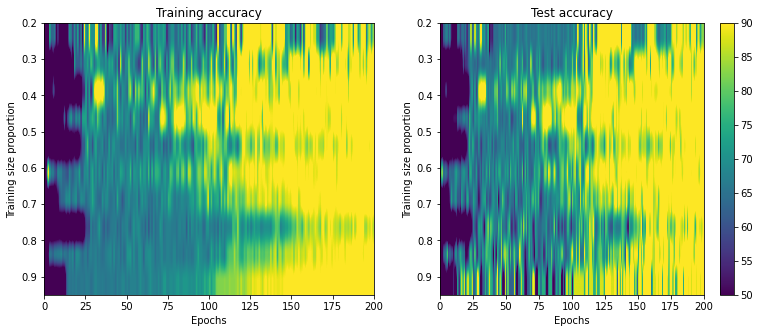

In [10]:
from sklearn.model_selection import train_test_split

# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

  return ANNiris,lossfun,optimizer


  # train the model

# global parameter
numepochs = 200

def trainTheModel(trainProp):

  # initialize losses
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # separate train from test data
    # Note 1: unique split for each epoch!
    # Note 2: here we specify the training size, not the testing size!
    X_train,X_test, y_train,y_test = train_test_split(data,labels, train_size=trainProp)


    # forward pass and loss
    yHat = ANNiris(X_train)
    loss = lossfun(yHat,y_train)
    
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # compute training accuracy
    trainAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y_train).float()).item() )
    
    # test accuracy
    predlabels = torch.argmax( ANNiris(X_test),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y_test).float()).item() )
  
  # function output
  return trainAcc,testAcc


trainSetSizes = np.linspace(.2,.95,10)

allTrainAcc = np.zeros((len(trainSetSizes),numepochs))
allTestAcc = np.zeros((len(trainSetSizes),numepochs))

for i in range(len(trainSetSizes)):
  
  # create a model
  ANNiris,lossfun,optimizer = createANewModel()
  
  # train the model
  trainAcc,testAcc = trainTheModel(trainSetSizes[i])
  
  # store the results
  allTrainAcc[i,:] = trainAcc
  allTestAcc[i,:] = testAcc


fig,ax = plt.subplots(1,2,figsize=(13,5))

ax[0].imshow(allTrainAcc,aspect='auto',
             vmin=50,vmax=90, extent=[0,numepochs,trainSetSizes[-1],trainSetSizes[0]])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training accuracy')

p = ax[1].imshow(allTestAcc,aspect='auto',
             vmin=50,vmax=90, extent=[0,numepochs,trainSetSizes[-1],trainSetSizes[0]])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training size proportion')
ax[1].set_title('Test accuracy')
fig.colorbar(p,ax=ax[1])

plt.show()

# 3. Data Loader

torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])


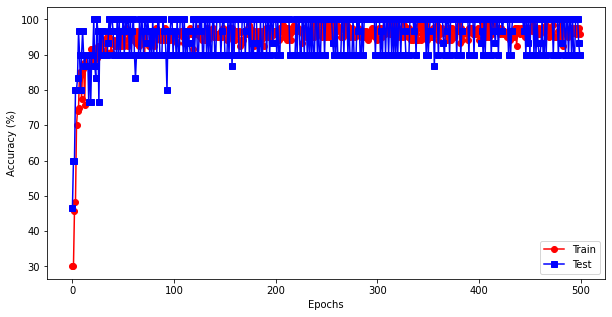

In [11]:
from torch.utils.data import DataLoader

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = \
                              train_test_split(data, labels, train_size=.8)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
train_loader = DataLoader(train_data,shuffle=True,batch_size=12)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

X,y

# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

  return ANNiris,lossfun,optimizer


# train the model

# global parameter
numepochs = 500

def trainTheModel():

  # initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):


    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...


    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
  
  # function output
  return trainAcc,testAcc

# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc = trainTheModel()


# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

# optional zoom-in to final epochs
# plt.xlim([300,500])
# plt.ylim([90,100.5])

plt.show()

# 4. Train-Dev-Test

In [12]:
### create fake dataset (same as in previous videos)

fakedata = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T
fakelabels = np.arange(10)>4
print(fakedata), print(' ')
print(fakelabels)

# specify sizes of the partitions
# order is train,devset,test
partitions = [.8,.1,.1]

# split the data (note the third input, and the TMP in the variable name)
train_data,testTMP_data, train_labels,testTMP_labels = \
                   train_test_split(fakedata, fakelabels, train_size=partitions[0])

# now split the TMP data
split = partitions[1] / np.sum(partitions[1:])
devset_data,test_data, devset_labels,test_labels = \
              train_test_split(testTMP_data, testTMP_labels, train_size=split)




# print out the sizes
print('Training data size: ' + str(train_data.shape))
print('Devset data size: '   + str(devset_data.shape))
print('Test data size: '     + str(test_data.shape))
print(' ')

# print out the train/test data
print('Training data: ')
print(train_data)
print(' ')

print('Devset data: ')
print(devset_data)
print(' ')

print('Test data: ')
print(test_data)

# partition sizes in proportion
partitions = np.array([.8,.1,.1])
print('Partition proportions:')
print(partitions)
print(' ')

# convert those into integers
partitionBnd = np.cumsum(partitions*len(fakelabels)).astype(int)
print('Partition boundaries:')
print(partitionBnd)
print(' ')


# random indices
randindices = np.random.permutation(range(len(fakelabels)))
print('Randomized data indices:')
print(randindices)
print(' ')


# select rows for the training data
train_dataN   = fakedata[randindices[:partitionBnd[0]],:]
train_labelsN = fakelabels[randindices[:partitionBnd[0]]]

# select rows for the devset data
devset_dataN   = fakedata[randindices[partitionBnd[0]:partitionBnd[1]],:]
devset_labelsN = fakelabels[randindices[partitionBnd[0]:partitionBnd[1]]]

# select rows for the test data
test_dataN   = fakedata[randindices[partitionBnd[1]:],:]
test_labelsN = fakelabels[randindices[partitionBnd[1]:]]


# print out the sizes
print('Training data size: ' + str(train_dataN.shape))
print('Devset size: '        + str(devset_dataN.shape))
print('Test data size: '     + str(test_dataN.shape))
print(' ')

# print out the train/test data
print('Training data: ')
print(train_dataN)
print(' ')

print('Devset data: ')
print(devset_dataN)
print(' ')

print('Test data: ')
print(test_dataN)

[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
 
[False False False False False  True  True  True  True  True]
Training data size: (8, 4)
Devset data size: (1, 4)
Test data size: (1, 4)
 
Training data: 
[[ 71  72  73  74]
 [ 31  32  33  34]
 [ 91  92  93  94]
 [ 81  82  83  84]
 [101 102 103 104]
 [ 61  62  63  64]
 [ 51  52  53  54]
 [ 21  22  23  24]]
 
Devset data: 
[[41 42 43 44]]
 
Test data: 
[[11 12 13 14]]
Partition proportions:
[0.8 0.1 0.1]
 
Partition boundaries:
[ 8  9 10]
 
Randomized data indices:
[5 6 8 2 3 4 9 0 1 7]
 
Training data size: (8, 4)
Devset size: (1, 4)
Test data size: (1, 4)
 
Training data: 
[[ 61  62  63  64]
 [ 71  72  73  74]
 [ 91  92  93  94]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [101 102 103 104]
 [ 11  12  13  14]]
 
Devset data: 
[[21 22 23 24]]
 
Test data: 
[[81 82 83 84]]


# Reference

These are codes learned from the Udemy

COURSE: A deep understanding of deep learning

TEACHER: Mike X Cohen, sincxpress.com

COURSE URL: udemy.com/course/dudl/?couponCode=202109